In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


# Lecture des données

Nous chargeons les données dans une structure de type Series.

Nous séparons les donneés de test et d'entrainement en 80%

In [2]:
import pandas as pd

cafe_df = pd.read_csv('auscafe.csv', parse_dates=['date'])
cafe = pd.Series(data=cafe_df['Y'].values, index=cafe_df['date'])

print(cafe.head())

date
1982-04-01    0.3424
1982-05-01    0.3421
1982-06-01    0.3287
1982-07-01    0.3385
1982-08-01    0.3315
dtype: float64


In [37]:
train_size = int(len(cafe) * 0.8)
train, test = cafe[:train_size], cafe[train_size:]


# Simple Exponential Smoothing

Nous faisons un premier exemple de lissage exponentiel simple en laissant la bibliothèque déterminer le paramètre alpha.
La prédiction est la moyenne pondérée des observations. Plus les observations sont anciennes plus leur pondération baisse. Nous pensons que ceci fonctionne bien losque la tendence est stable et une absence de saisonalité.



In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

train = train.asfreq("MS")
ses_model = SimpleExpSmoothing(train, initialization_method="estimated").fit()
ses_forecast = ses_model.forecast(len(test))

rmse = np.sqrt(mean_squared_error(test, ses_forecast))
print(f'RMSE: {rmse:.2f}')

mape = mean_absolute_percentage_error(test, ses_forecast)
print(f'MAPE: {mape:.2f}')

RMSE: 0.64
MAPE: 0.16


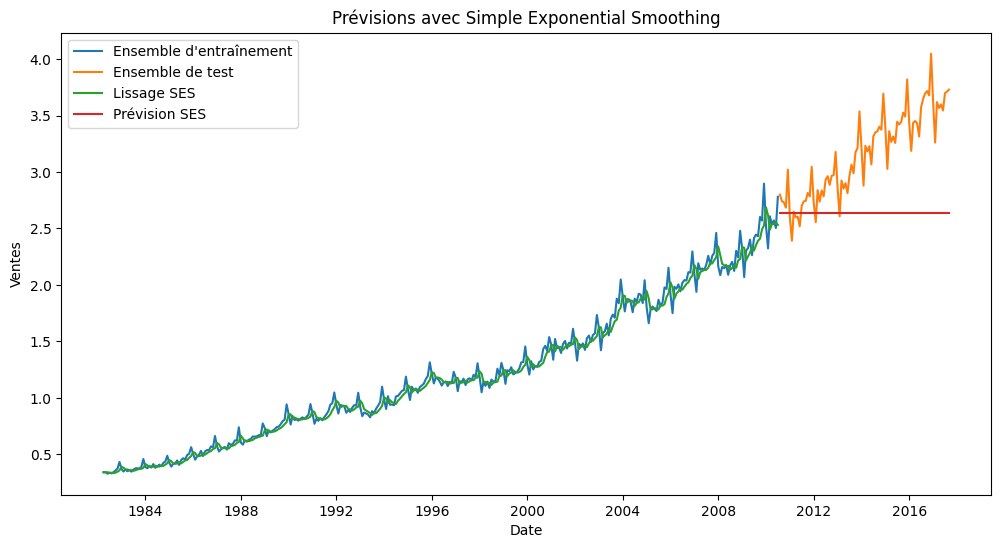

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train, label='Ensemble d\'entraînement')
plt.plot(test, label='Ensemble de test')
plt.plot(ses_model.fittedvalues, label='Lissage SES')
plt.plot(ses_forecast, label='Prévision SES')
plt.title('Prévisions avec Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.show()


# Modèle de Holt

Dans ce code nous utilisons la fonction Holt afin de faire le lissage et de faire des prédictions.

Nous voyons que le modèle de Holt évidemment mieux. Ce modèle est capable de capturer les variations de tendance en introduisant en paramètre supplémentaire bêta.

In [61]:
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

train = train.asfreq('MS')
test = test.asfreq('MS')

# création d'une petie fonction qui va retourner directement toutes les valeurs attendues i.e modèle prévisions et rmse mape
def evaluate_holt(exponential, damped_trend):
    model = Holt(train, exponential=exponential, damped_trend=damped_trend, initialization_method="estimated").fit()
    forecast = model.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = mean_absolute_percentage_error(test, forecast)
    return model, forecast, rmse, mape

combinations = [(False, False), (True, False), (False, True), (True, True)]
results = {}

# mettre un texte comme clé de dict et assigner les résultats pour les afficher plus simplement
for exp, damp in combinations:
    model, forecast, rmse, mape = evaluate_holt(exp, damp)
    key = f'exponential={exp}, damped_trend={damp}'
    results[key] = {'model': model, 'forecast': forecast, 'rmse': rmse, 'mape': mape}

for key, value in results.items():
    print(f'{key}: RMSE={value["rmse"]:.2f}, MAPE={value["mape"]:.2f}')


exponential=False, damped_trend=False: RMSE=0.33, MAPE=0.08
exponential=True, damped_trend=False: RMSE=0.28, MAPE=0.07
exponential=False, damped_trend=True: RMSE=0.29, MAPE=0.07
exponential=True, damped_trend=True: RMSE=0.24, MAPE=0.06


In [62]:
# Trouver la meilleure combinaison de paramètres
# lambda qui fait simplement un min de chaque valeurs pour trouver le min du dict
best_combination = min(results, key=lambda k: results[k]['rmse'])
best_model = results[best_combination]['model']
best_forecast = results[best_combination]['forecast']
best_rmse = results[best_combination]['rmse']
best_mape = results[best_combination]['mape']

print(f'La meilleure combinaison est: {best_combination}')
print(f'RMSE: {best_rmse:.2f}')
print(f'MAPE: {best_mape:.2f}')


La meilleure combinaison est: exponential=True, damped_trend=True
RMSE: 0.24
MAPE: 0.06


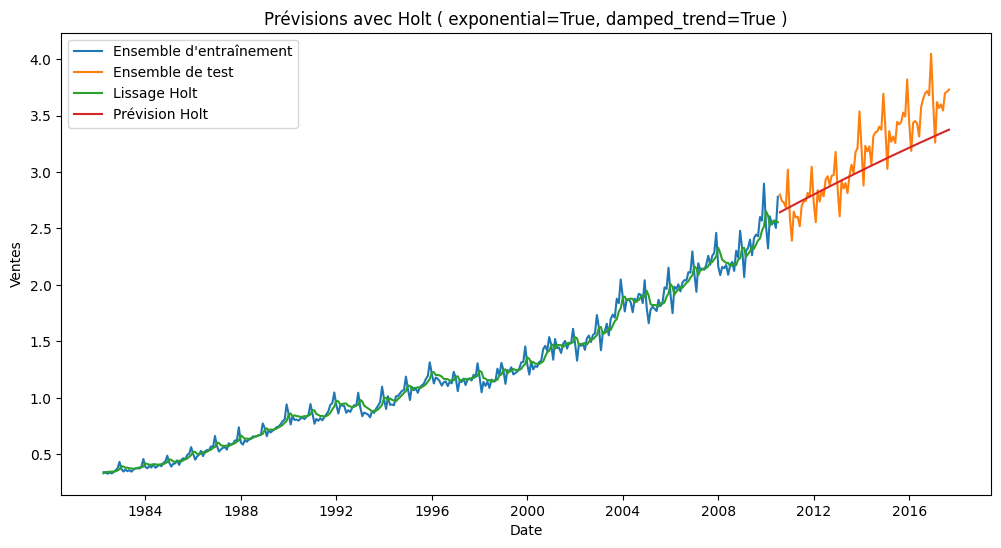

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train, label='Ensemble d\'entraînement')
plt.plot(test, label='Ensemble de test')
plt.plot(best_model.fittedvalues, label='Lissage Holt')
plt.plot(best_forecast, label='Prévision Holt')
plt.title(f'Prévisions avec Holt ( {best_combination} )')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.show()


# Modèle Holt-Winter

Dans cette troisième expérience nous utilisons le modèle de Holt-Winter

In [64]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import itertools

train = train.asfreq('MS')
test = test.asfreq('MS')

def evaluate_holt_winters(trend, seasonal, damped_trend, use_boxcox):
    try:
        model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, damped_trend=damped_trend, use_boxcox=use_boxcox).fit()
        forecast = model.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = mean_absolute_percentage_error(test, forecast)
        return model, forecast, rmse, mape
    except (ValueError, np.linalg.LinAlgError) as e:
        print(f"Combination {trend}-{seasonal}-{damped_trend}-{use_boxcox} failed: {e}")
        return None, None, np.inf, np.inf

param_grid = {
    'trend': ['add'],
    'seasonal': ['add'],
    'damped_trend': [True, False],
    'use_boxcox': [True, False]}


results = {}

# dézipper les deux listes de valeurs
# parcourir le produit cartérsien des valeurs et zipper les clés
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# pour chaque combinaison effectuer la prédiction Holt winters
for params in combinations:
    model, forecast, rmse, mape = evaluate_holt_winters(params['trend'], params['seasonal'], params['damped_trend'], params['use_boxcox'])
    if model is not None:
        key = f"trend={params['trend']}, seasonal={params['seasonal']}, damped_trend={params['damped_trend']}, boxcox={params['use_boxcox']}"
        results[key] = {'model': model, 'forecast': forecast, 'rmse': rmse, 'mape': mape}

best_rmse = min(results.items(), key=lambda x: x[1]['rmse'])
best_mape = min(results.items(), key=lambda x: x[1]['mape'])

best_model_rmse = best_rmse[1]['model']
best_forecast_rmse = best_rmse[1]['forecast']

best_model_mape = best_mape[1]['model']
best_forecast_mape = best_mape[1]['forecast']

print(f'Best RMSE: {best_rmse[0]} with RMSE={best_rmse[1]["rmse"]:.2f}, MAPE={best_rmse[1]["mape"]:.2f}')
print(f'Best MAPE: {best_mape[0]} with RMSE={best_mape[1]["rmse"]:.2f}, MAPE={best_mape[1]["mape"]:.2f}')

for key, value in results.items():
    print(f'{key}: RMSE={value["rmse"]:.2f}, MAPE={value["mape"]:.2f}')


Best RMSE: trend=add, seasonal=add, damped_trend=False, boxcox=False with RMSE=0.11, MAPE=0.03
Best MAPE: trend=add, seasonal=add, damped_trend=False, boxcox=False with RMSE=0.11, MAPE=0.03
trend=add, seasonal=add, damped_trend=True, boxcox=True: RMSE=0.12, MAPE=0.03
trend=add, seasonal=add, damped_trend=True, boxcox=False: RMSE=0.12, MAPE=0.03
trend=add, seasonal=add, damped_trend=False, boxcox=True: RMSE=0.16, MAPE=0.05
trend=add, seasonal=add, damped_trend=False, boxcox=False: RMSE=0.11, MAPE=0.03


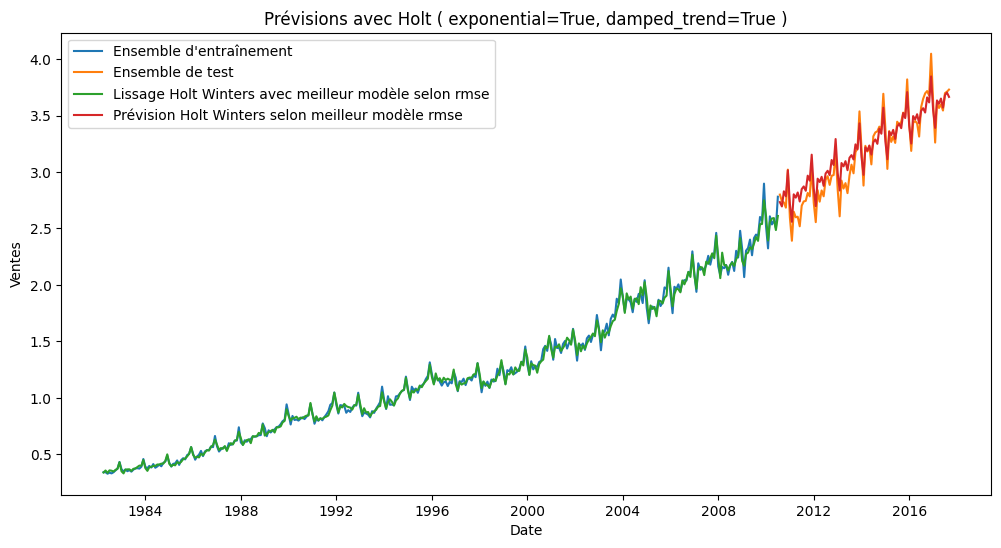

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train, label='Ensemble d\'entraînement')
plt.plot(test, label='Ensemble de test')
plt.plot(best_model_rmse.fittedvalues, label='Lissage Holt Winters avec meilleur modèle selon rmse')
plt.plot(best_forecast_rmse, label='Prévision Holt Winters selon meilleur modèle rmse')
plt.title(f'Prévisions avec Holt ( {best_combination} )')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.show()


# Résultats et conclusion

TODO: commenter les résultat et expliquer RMSE MAPE.

TODO: décrire les équations des modèles 

TODO: expliquer leurs cas d'utilisation 



